In [1]:
import numpy as np
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import random
import sys
import copy
import math

# Module 10 - Programming Assignment (Summer)

# The Problem

Last week we left our agent with a simple logistic regression that it could use to classify a picture from its cheap visual "sensor" as hills or not hills. We *could* make a logistic regression for each train type (hills/not hills, plains/not plains, swamp/not swamp, forest/not forest) and pick the one with the largest probability but that's exactly the kind of a problem a Multi-Layer Perceptron (MLP) Artificial Neural Network (ANN) was designed to solve.

Here are the "pure" images again:

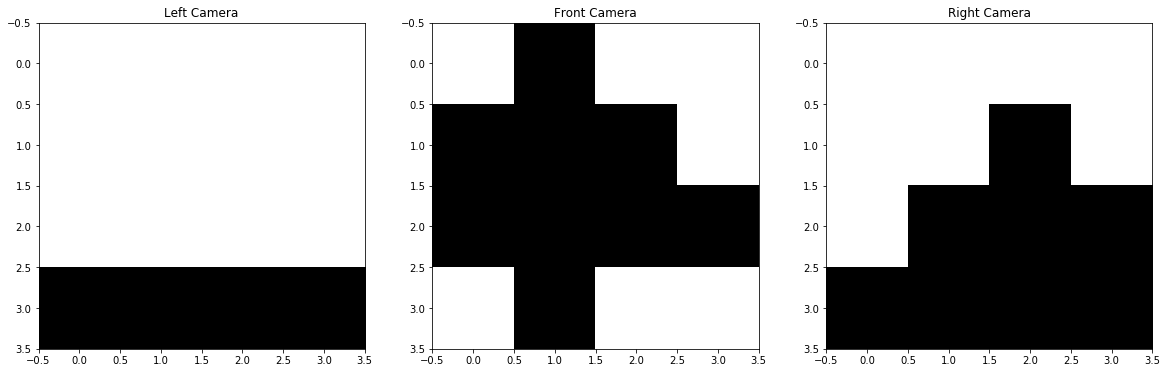

In [2]:
plain =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 1.0, 1.0, 1.0]
forest = [0.0, 1.0, 0.0, 0.0,1.0, 1.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0,0.0, 1.0, 0.0, 0.0]
hills =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 1.0, 0.0,0.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0]
swamp =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 0.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0]

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)
pixels = np.array([255 - p * 255 for p in plain], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Left Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 2)
pixels = np.array([255 - p * 255 for p in forest], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Front Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 3)
pixels = np.array([255 - p * 255 for p in hills], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Right Camera")
axes.imshow(pixels, cmap='gray')

plt.show()
plt.close()

which would be plains, forest and hills respectively.

## The Assignment

For this programming assignment your tasks are:

1. Write an ANN regression that simply determines what kind of terrain it is. This is a multi-class problem.
2. You will also evaluate your model for at least 3 different numbers of nodes in the hidden layer (2, 4, 8) and determine which one has the lowest *error rate*.

For a starting point, you can refer to **module-10-pseudocode.pdf** and the Self-Check.

## Data

As before, we have clean examples of the different types of terrain but based on the location, the registration can be a bit off for some of the types and the visual sensor is often blurry.

Here are the clean examples with different registrations: 

In [3]:
clean_data = {
    "plains": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, "plains"]
    ],
    "forest": [
        [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, "forest"],
        [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, "forest"]
    ],
    "hills": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, "hills"]
    ],
    "swamp": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "swamp"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, "swamp"]        
    ]
}

Let's create a function that allows us to view any of these:

In [4]:
def view_sensor_image( data):
    figure = plt.figure(figsize=(4,4))
    axes = figure.add_subplot(1, 1, 1)
    pixels = np.array([255 - p * 255 for p in data[:-1]], dtype='uint8')
    pixels = pixels.reshape((4, 4))
    axes.set_title( "Left Camera:" + data[-1])
    axes.imshow(pixels, cmap='gray')
    plt.show()
    plt.close()

"I think that I shall never see a thing so lovely as a tree."

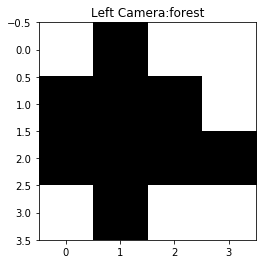

In [5]:
view_sensor_image( clean_data[ "forest"][0])

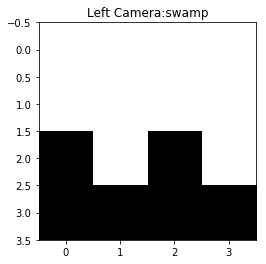

In [6]:
view_sensor_image( clean_data["swamp"][0])

The data that comes in, however, is noisy. The values are never exactly 0 and 1. In order to mimic this we need a `blur` function.

We will assume that noise is normally distributed. For values that should be 0, the noisy values are distributed $N(0.10, 0.05)$. For values should be 1, the noisy values are distributed $N(0.9, 0.10)$.

In [7]:
def blur( data):
    def apply_noise( value):
        if value < 0.5:
            v = random.gauss( 0.10, 0.05)
            if v < 0.0:
                return 0.0
            if v > 0.75:
                return 0.75
            return v
        else:
            v = random.gauss( 0.90, 0.10)
            if v < 0.25:
                return 0.25
            if v > 1.00:
                return 1.00
            return v
    noisy_readings = [apply_noise( v) for v in data[0:-1]]
    return noisy_readings + [data[-1]]

We can see how this affects what the agent *actually* sees.

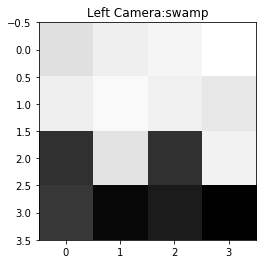

In [8]:
view_sensor_image( blur( clean_data["swamp"][0]))

You are going to want to write four (4) functions:

1. `generate_data`
2. `learn_model`
3. `apply_model`
4. `generate_validation_curves`


### `generate_data`

With the clean examples and the `blur` function, we have an unlimited amount of data for training and testing our classifier, an ANN that determines if a sensor image is hills, swamp, forest or plains.

In classification, there is a general problem called the "unbalanced class problem". In general, we want our training data to have the same number of classes for each class. This means you should probably generate training data with, say, 100 of each type.

But what do we do about the class label with the neural network?

In this case, we can do "one hot". Instead of `generate_data` outputing a single 0 or 1, it should output a vector of 0's and 1's so that $y$ is now a vector as well as $x$. We can use the first position for hill, the second for swamp, the third for forest and the fourth for plains:

```
[0, 1, 0, 0]
```

what am I? swamp.

Unlike logistic regression, you should set the *biases* inside the neural network (the implict $x_0$ = 1) because there are going to be lot of them (one for every hidden and output node).

`generate_data` now only needs to take how many you want of each class:

`generate_data( clean_data, 100)`

generates 100 hills, 100 swamp, 100 forest, 100 plains and transforms $y$ into the respective "one hot" encoding.

### `learn_model`

`learn_model` is the function that takes in training data and actually learns the ANN. If you're up to it, you can implement a vectorized version using Numpy but you might start with the loopy version first.

*In the lecture, I mentioned that you usually should mean normalize your data but you don't need to do that in this case because the data is already on the range 0-1.*

You should add a parameter to indicate how many nodes the hidden layer should have.

When verbose is True, you should print out the error so you can see that it is getting smaller.

When developing your algorithm, you need to watch the error so you'll set verbose=True to start. You should print it out every iteration and make sure it is declining. You'll have to experiment with both epsilon and alpha; and it doesn't hurt to make alpha adaptive (if the error increases, make alpha = alpha / 10).

When you know that your algorithm is working, change your code so that the error is printed out only every 1,000 iterations (it takes a lot of iterations for this problem to converge, depending on your parameter values--start early).

`learn_model` returns the neural network. The hidden layer will be one vector of thetas for each hidden node. And the output layer will have its own thetas, one for each output (4 in this case). Return it as a Tuple: (List of List, List of List).

### `apply_model`

`apply_model` takes the ANN (the model) and either labeled or unlabeled data. If the data is unlabeled, it will return predictions for each observation as a List of Tuples of the inferred value (0 or 1) and the actual probability (so something like (1, 0.73) or (0, 0.19) so you have [(0, 0.30), (1, 0.98), (0, 0.87), (0, 0.12)]. Note that unlike the logistic regression, the threshold for 1 is not 0.5 but which value is largest (0.98 in this case).

If the data is labeled, you will return a List of List of Tuples of the actual value (0 or 1) and the predicted value (0 or 1). For a single data point, you'll have the pairs of actual values [(0, 1), (0, 0), (0, 0), (1, 0)] is a misclassification and [(0, 0), (0, 0), (1, 1), (0, 0)] will be a correct classification. Then you have a List of *those*, one for each observation.

### `generate_validation_curves`

The `generate_validation_curves` is going to be a bit different than the confusion matrix version last week. It should take the information required to plot validation curves over the train and test sets for the specified parameter values.

So basically, you have:

1. generate training set
2. generate test set
3. loop over [2, 4, 8]
    1. train model and apply to train data, calculate error rate.
    2. apply to test data and calculae error rate.
    3. plot both curves.

The net results should be one plot of 2 curves over 3 parameter values. Please state in a markdown field afterwards which number of hidden nodes had the lowest error rate.

**As always when working with Lists or Lists of Lists, be very careful when you are modifying these items in place that this is what you intend (and not to be modifying a copy)**

---

## Helper Functions

&nbsp;

**Print HTML Table**

This function prints a nicely formated HTML table given a list of lists.

In [9]:
def print_html_table(data):
    print_results = []
    for row in data:
        row_list = []
        for x in row:
            if type(x) == float:
                x = round(x, 2)
            row_list.append(x)
        print_results.append(row_list)
    display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in print_results)
        )
     ))

&nbsp;

**Generate Labeled Data**

This function is used in generate_data to generate n data points of each of the different types of data.  For example, if passed n=10, label="hills", and one_hot_index=0, it will generate 10 blurred hills test data examples.  This function is called 4 times, one for each of the different types of data, in the generate_data function.

In [10]:
def generate_labeled_data(data, n, label, one_hot_index, data_out):
    y = [0.0, 0.0, 0.0, 0.0]
    y[one_hot_index] = 1.0
    loop = len(data[label]) - 1

    index = 0
    for i in range(n):
        blurred_data = blur(data[label][index])
        blurred_data[-1] = y  # TODO: make sure I don't need to make a deep copy of this
        data_out.append(blurred_data)

        if index < loop:
            index += 1
        else:
            index = 0

&nbsp;

**Initialize Network**

This function initializes the neural network given the test data, a number of hidden nodes, and a number of output nodes.  It determines the number of thetas for the hidden nodes and output nodes, then sets random values between 0 and 1 for each of the thetas of the hidden nodes and output nodes.  The network is represented as a dictionary, with two keys: 'hidden_node_thetas' and 'output_node_thetas' that each point to a list of lists of thetas. Throughout the execution of this program, various key value pairs get added to the dictionary to represent the neural network.

In [11]:
def initialize_network(data, num_hidden_nodes, num_output_nodes):
    num_hidden_node_thetas = len(data[0])
    num_output_node_thetas = num_hidden_nodes + 1
    network = {'hidden_node_thetas': [], 'output_node_thetas': []}

    for i in range(num_hidden_nodes):
        hidden_node_thetas = [random.uniform(0, 1) for x in range(num_hidden_node_thetas)]
        network['hidden_node_thetas'].append(hidden_node_thetas)

    for i in range(num_output_nodes):
        output_node_thetas = [random.uniform(0, 1) for x in range(num_output_node_thetas)]
        network['output_node_thetas'].append(output_node_thetas)

    return network

&nbsp;

**Dot Product**

This function calculates the dot product of a list of thetas and a list of xs.  The dot product of two vectors a and b is a⋅b = a1b1 + a2b2 + a3b3 +...+ anbn.  This is used to calculate y hat.
 

In [12]:
def dot_product(thetas, xs):
    z = 0.0

    for i in range(len(thetas)):
        z += thetas[i] * xs[i]

    return z

&nbsp;

**Calculate y hat**

This function calculates y hat given a list of thetas and a list of xs.  The formula for y hat is:
$$\hat{y} = \frac{1}{1+e^{-\theta_0}}$$

In [13]:
def calculate_yhat(thetas, xs):
    z = dot_product(thetas, xs)
    yhat = 1.0 / (1.0 + math.e ** (-z))

    return yhat

&nbsp;

**Add Bias**

Given a list, this function adds a bias (1) to the front of the list.  This is used to add biases to the hidden nodes and output nodes in the execution of the neural network.

In [14]:
def add_bias(xs):
    xs_with_bias = copy.deepcopy(xs)
    xs_with_bias.insert(0, 1.0)

    return xs_with_bias

&nbsp;

**Calculate Hidden Node Outputs**

Given the network and a set of input nodes, this function calculates the output of each of the hidden nodes.  The list of outputs is returned and then stored in the network dictionary with key 'hidden_node_outputs'.  First, a bias is added to the input node list, then for each set of hidden node thetas, yhat is calculated with those thetas and the input nodes with bias.

In [15]:
def calculate_hidden_node_outputs(network, input_nodes):
    hidden_node_outputs = []
    input_nodes_with_bias = add_bias(input_nodes[:len(input_nodes) - 1])

    for hidden_node_thetas in network['hidden_node_thetas']:
        hidden_node_output = calculate_yhat(hidden_node_thetas, input_nodes_with_bias)
        hidden_node_outputs.append(hidden_node_output)

    return hidden_node_outputs

&nbsp;

**Calculate Output Node Outputs**

Given the network, this function calculates the output of each of the output nodes.  The list of outputs is returned and then stored in the network dictionary with key 'output_node_outputs'. First, a bias is added to the list of hidden node outputs, then for each set of output node thetas, yhat is calculated with those thetas and the hidden nodes with bias.

In [16]:
def calculate_output_node_outputs(network):
    output_node_outputs = []
    hidden_node_outputs_with_bias = add_bias(network['hidden_node_outputs'])

    for output_node_thetas in network['output_node_thetas']:
        output_node_output = calculate_yhat(output_node_thetas, hidden_node_outputs_with_bias)
        output_node_outputs.append(output_node_output)

    return output_node_outputs

&nbsp;

**Calculate Delta-O**

Given y and yhat, this function calculates delta_o using the formula yhat \* (1.0 - yhat) \* (y - yhat).

In [17]:
def calculate_delta_o(y, yhat):
    delta_o = yhat * (1.0 - yhat) * (y - yhat)

    return delta_o

&nbsp;

**Calculate Delta-Os**

Given a network and the actual output values of the current point in the data set, this function calculates delta_o.  For each of the actual output values, it gets the corresponding output node outputs (yhats) and uses the calculate_delta_o function on the y and yhat values.  The delta_os are returned and stored in the network dictionary with key 'delta_os'.

In [18]:
def calculate_delta_os(network, ys):
    delta_os = []

    for i in range(len(ys)):
        yhat = network['output_node_outputs'][i]
        y = ys[i]

        delta_o = calculate_delta_o(y, yhat)
        delta_os.append(delta_o)

    return delta_os

&nbsp;

**Calculate Delta-H**

Given yhat, thetas, and delta_os, this function calculates delta_o.

In [19]:
def calculate_delta_h(yhat, thetas, delta_os):
    delta_h = yhat * (1 - yhat)

    summation = 0.0
    for i in range(len(thetas)):
        theta = thetas[i]
        delta_o = delta_os[i]
        summation += (theta * delta_o)

    delta_h = delta_h * summation

    return delta_h

&nbsp;

**Calculate Delta-Hs**

Given the network, this function calculates the delta h values for the network.  It uses the previously calculated delta os, the thetas of the output nodes that it is connected to, and yhat that is the output of each of the hidden nodes.  Each of those parameters are passed to the calculate_delta_h function.  The delta hs are returned and then stored in the network dictionary with key 'delta_hs'.

In [20]:
def calculate_delta_hs(network):
    delta_hs = []
    delta_os = network['delta_os']

    for i in range(len(network['hidden_node_thetas'])):
        thetas = []
        for output_node_thetas in network['output_node_thetas']:
            thetas.append(output_node_thetas[i + 1])

        yhat = network['hidden_node_outputs'][i]
        delta_h = calculate_delta_h(yhat, thetas, delta_os)
        delta_hs.append(delta_h)

    return delta_hs

&nbsp;

**Update Output Node Thetas**

Given the network and some alpha, this function updates each of the thetas for the output nodes.  It gets the delta_o for each output node, adds a bias to the hidden node outputs, then for each theta updates that theta with formula theta = theta + alpha * delta_o * hidden_node_y

In [21]:
def update_output_node_thetas(network, alpha):
    for i in range(len(network['output_node_thetas'])):
        thetas = network['output_node_thetas'][i]
        delta_o = network['delta_os'][i]

        hidden_node_outputs_with_bias = add_bias(network['hidden_node_outputs'])
        for j in range(len(thetas)):
            hidden_node_y = hidden_node_outputs_with_bias[j]
            thetas[j] = thetas[j] + alpha * delta_o * hidden_node_y

&nbsp;

**Update Hidden Node Thetas**

Given the network, some alpha, and a set of input nodes, this function udpates all the hidden node thetas of the network.  It adds a bias to the input nodes, then for each set of thetas, gets the corresponding delta_h, and updates each theta with formula theta = theta + alpha * delta_h * xi where xi is the corresponding input node value.

In [22]:
def update_hidden_node_thetas(network, alpha, input_nodes):
    input_nodes_with_bias = add_bias(input_nodes[:len(input_nodes) - 1])  # use only input node xs, without the y

    for i in range(len(network['hidden_node_thetas'])):
        thetas = network['hidden_node_thetas'][i]
        delta_h = network['delta_hs'][i]

        for j in range(len(thetas)):
            xi = input_nodes_with_bias[j]
            thetas[j] = thetas[j] + alpha * delta_h * xi

&nbsp;

**Calculate Individual Error**

Given ys and yhats, this function calculates a single error point that is part of a summation of errors used as a stopping point for the learning algorithm.  This is the logistic regression error formula.

In [23]:
def calculate_individual_error(ys, yhats):
    error_summation = 0
    for i in range(len(ys)):
        y = ys[i]
        yhat = yhats[i]

        if yhat == 0 and (1 - yhat) == 0:
            pass

        elif yhat == 0:
            error_summation += ((1 - y) * math.log(1 - yhat))

        elif (1 - yhat) == 0:
            error_summation += (y * math.log(yhat))

        else:
            error_summation += (y * math.log(yhat) + (1 - y) * math.log(1 - yhat))

    return error_summation

&nbsp;

**Calculate Error**

Given the input data, the network, and some alpha, this function calculates the error for the network which is used as a stopping point for the learning algorithm.  It does one iteration over the training data, calculates the errors, sums them, then sums over all the data to get the total error of the data set.

In [24]:
def calculate_error(data, network, alpha):
    error = 0
    test_network = {}
    test_network['hidden_node_thetas'] = copy.deepcopy(network['hidden_node_thetas'])
    test_network['output_node_thetas'] = copy.deepcopy(network['output_node_thetas'])

    for input_nodes in data:
        test_network['hidden_node_outputs'] = calculate_hidden_node_outputs(network, input_nodes)
        test_network['output_node_outputs'] = calculate_output_node_outputs(network)

        ys = input_nodes[-1]
        yhats = test_network['output_node_outputs']
        
        error += calculate_individual_error(ys, yhats)
            
        test_network['delta_os'] = calculate_delta_os(network, ys)
        test_network['delta_hs'] = calculate_delta_hs(test_network)  # TODO check this

        update_output_node_thetas(test_network, alpha)
        update_hidden_node_thetas(test_network, alpha, input_nodes)

    return -1/(error / len(data))

&nbsp;

**Get Labeled Data Results**

This function is used in apply model to get results for labeled data.  Given a list of actual values and predicted values, it creates a List of List of Tuples of the actual value (0 or 1) and the predicted value (0 or 1).

In [25]:
def get_labeled_data_results(actuals, predictions):
    result = []
    max_prediction_index = predictions.index(max(predictions))

    for i in range(len(predictions)):
        actual = actuals[i]
        if i != max_prediction_index:
            prediction = 0.0
            result.append((actual, prediction))

        else:
            prediction = 1.0
            result.append((actual, prediction))

    return result

&nbsp;

**Get Unlabeled Data Results**

This function is used in apply model to get results for unlabeled data.  Given a list of output node outputs, it returns predictions as a List of Tuples of the inferred value (0 or 1) and the actual probability.

In [26]:
def get_unlabeled_data_results(predictions):
    result = []
    max_prediction_index = predictions.index(max(predictions))

    for i in range(len(predictions)):
        prediction = predictions[i]
        if i != max_prediction_index:
            result.append((0, 1 - prediction))

        else:
            result.append((1, prediction))

    return result

&nbsp;

**Calculate Validation Curve Error**

Given results from applying the model this function calculates the error rate that will be plotted on the validation curves.

In [27]:
def calculate_validation_curve_error(results):
    n = 0.0
    errors = 0.0
    not_errors = 0.0
    for result in results:
        for point in results:
            error = False
            for pair in point:
                if pair[0] != pair[1]:
                    error = True
            if error:
                errors += 1.0

            else:
                not_errors += 1.0
            n += 1.0

    error_rate = errors / n
    return error_rate

---


## Main Functions

Use `generate_data` to generate 10 blurred "hills" examples with balanced (same number of) "non hills" examples to see that the function is working.

In [28]:
def generate_data(data, n):
    data_out = []

    generate_labeled_data(data, n, "hills", 0, data_out)
    generate_labeled_data(data, n, "swamp", 1, data_out)
    generate_labeled_data(data, n, "forest", 2, data_out)
    generate_labeled_data(data, n, "plains", 3, data_out)

    return data_out

results = generate_data( clean_data, 10)
print_html_table(results)

0.12,0.24,0.1,0.12,0.11,0.06,0.99,0.14,0.05,0.95,0.8,0.62,1.0,1.0,0.88,0.91,"[1.0, 0.0, 0.0, 0.0]"
0.1,0.01,0.06,0.12,0.09,0.9,0.03,0.09,0.83,1.0,0.77,0.09,1.0,0.94,1.0,0.86,"[1.0, 0.0, 0.0, 0.0]"
0.18,0.11,0.05,0.09,0.89,0.18,0.13,0.07,0.96,0.89,0.04,0.09,0.94,1.0,0.94,0.13,"[1.0, 0.0, 0.0, 0.0]"
0.08,0.11,0.16,0.1,0.13,0.01,0.08,1.0,0.11,0.07,0.88,1.0,0.17,0.9,0.89,0.85,"[1.0, 0.0, 0.0, 0.0]"
0.12,0.02,0.12,0.08,0.15,0.08,0.92,0.19,0.08,0.89,1.0,0.76,0.98,0.75,0.9,0.93,"[1.0, 0.0, 0.0, 0.0]"
0.02,0.09,0.16,0.14,0.05,0.74,0.05,0.23,0.94,0.8,0.95,0.04,1.0,0.86,0.98,0.71,"[1.0, 0.0, 0.0, 0.0]"
0.06,0.09,0.07,0.09,0.81,0.09,0.08,0.0,1.0,1.0,0.1,0.06,0.85,0.97,0.77,0.14,"[1.0, 0.0, 0.0, 0.0]"
0.09,0.15,0.1,0.09,0.06,0.0,0.12,0.79,0.15,0.04,0.93,0.8,0.18,0.95,0.98,0.97,"[1.0, 0.0, 0.0, 0.0]"
0.05,0.09,0.08,0.12,0.09,0.09,0.95,0.11,0.12,0.92,0.85,0.86,1.0,0.96,0.84,0.75,"[1.0, 0.0, 0.0, 0.0]"
0.11,0.09,0.13,0.18,0.14,0.87,0.11,0.07,1.0,1.0,0.81,0.1,0.85,0.7,0.83,0.89,"[1.0, 0.0, 0.0, 0.0]"
0.11,0.11,0.08,0.04,0.03,0.09,0.0,0.0,0.99,0.06,0.94,0.11,0.94,0.98,0.79,0.85,"[0.0, 1.0, 0.0, 0.0]"


Use `learn_model` to learn a ANN model for classifying sensor images as hills, swamps, plains or forest. Use your `generate_data` function to generate a training set with 100 examples for each. **Set Verbose to True**

In [29]:
def learn_model(data, num_hidden_nodes, verbose=False):
    num_output_nodes = 4
    network = initialize_network(data, num_hidden_nodes, num_output_nodes)
    epsilon = 0.0000001
    alpha = 0.01 
    previous_error = 0.0
    current_error = float('-inf')
    iteration = 0

    while iteration < 5000 and abs(current_error - previous_error) > epsilon:
        iteration += 1
        for input_nodes in data:
            network['hidden_node_outputs'] = calculate_hidden_node_outputs(network, input_nodes)
            network['output_node_outputs'] = calculate_output_node_outputs(network)
            ys = input_nodes[-1]
            network['delta_os'] = calculate_delta_os(network, ys)
            network['delta_hs'] = calculate_delta_hs(network)  # TODO check this
            update_output_node_thetas(network, alpha)
            update_hidden_node_thetas(network, alpha, input_nodes)

        if verbose and iteration % 1000 == 0:
            print 'error: ', current_error

        previous_error = current_error
        current_error = calculate_error(data, network, alpha)

    return (network['hidden_node_thetas'], network['output_node_thetas'])


train_data = generate_data( clean_data, 100)
model = learn_model( train_data, 2, True)

error:  0.206107643318


Use `generate_data` to generate 100 blurred examples of each terrain and use this as your test data. Print out the first 10 results, one per line.

In [30]:
test_data = generate_data( clean_data, 100)

def apply_model(model, test_data, labeled=False):
    network = {}
    results = []
    network['hidden_node_thetas'] = model[0]
    network['output_node_thetas'] = model[1]

    for input_nodes in test_data:
        network['hidden_node_outputs'] = calculate_hidden_node_outputs(network, input_nodes)
        network['output_node_outputs'] = calculate_output_node_outputs(network)

        if labeled:
            actuals = input_nodes[-1]
            predictions = network['output_node_outputs']
            result = get_labeled_data_results(actuals, predictions)
            results.append(result)

        else:
            predictions = network['output_node_outputs']
            result = get_unlabeled_data_results(predictions)
            results.append(result)

    return results

results = apply_model( model, test_data)
print_html_table(results[:10])

"(1, 0.35362098036728606)","(0, 0.9801631565296267)","(0, 0.7715500697170055)","(0, 0.9997318138893858)"
"(1, 0.34534667793150614)","(0, 0.9887447494178527)","(0, 0.6610297637719382)","(0, 0.9998103951017542)"
"(1, 0.3503859566841123)","(0, 0.9779057913026928)","(0, 0.7914628276355503)","(0, 0.9996955021838536)"
"(1, 0.3618510758529733)","(0, 0.9098362456038307)","(0, 0.940963598299312)","(0, 0.9991594422836724)"
"(1, 0.39163143687692475)","(0, 0.6915335532530321)","(0, 0.9850369533407454)","(0, 0.9981017946508167)"
"(1, 0.38042096235605816)","(0, 0.8649318178145042)","(0, 0.9598776570308996)","(0, 0.9990444829600414)"
"(1, 0.3718730223636946)","(0, 0.874377602462437)","(0, 0.9574025042005582)","(0, 0.9990063709745849)"
"(1, 0.3667246442322372)","(0, 0.9448116706125491)","(0, 0.9032887105868185)","(0, 0.9994770565951082)"
"(1, 0.38066131442855994)","(0, 0.7726571234766814)","(0, 0.9781390606774684)","(0, 0.9984352123740948)"
"(0, 0.5956324428341659)","(1, 0.4880709688140995)","(0, 0.9926759439930405)","(0, 0.9970465307218273)"


Now that you're pretty sure your algorithm works (the error rate during training is going down, and you can evaluate `apply_model` results for its error rate, learn validation curves:

errors 120000.0
not_errors 40000.0


errors 120000.0
not_errors 40000.0


errors 1600.0
not_errors 158400.0


errors 2800.0
not_errors 157200.0


errors 0.0
not_errors 160000.0


errors 0.0
not_errors 160000.0


hidden_nodes [2, 4, 8]
train_error_values [0.75, 0.01, 0.0]
test_error_values [0.75, 0.0175, 0.0]


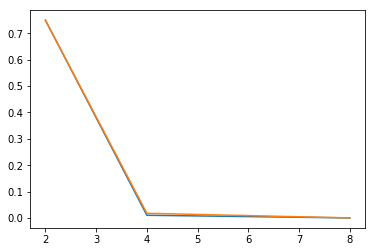

In [31]:
def generate_validation_curves(clean_data):
    train = generate_data(clean_data, 100)
    test = generate_data(clean_data, 100)
    train_error_values = []
    test_error_values = []
    hidden_nodes = [2, 4, 8]
    for n in hidden_nodes:
        model = learn_model(train, n)  # verbose is False now please!
        train_results = apply_model(model, train, True)
        test_results = apply_model(model, test, True)

        train_error_values.append(calculate_validation_curve_error(train_results))
        test_error_values.append(calculate_validation_curve_error(test_results))

    plt.plot(hidden_nodes, train_error_values)
    plt.plot(hidden_nodes, test_error_values)
    plt.show()

generate_validation_curves(clean_data)

which number of hidden nodes is best? **8**